In [1]:
library("devtools")
library("tidyverse")
library("EnhancedVolcano")

Loading required package: usethis

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2          v readr     2.1.4     
v forcats   1.0.0.9000     v stringr   1.5.0     
v ggplot2   3.4.3          v tibble    3.2.1     
v lubridate 1.9.2          v tidyr     1.3.0     
v purrr     1.0.1          
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: ggrepel



In [2]:
all_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/03.peak_assignment/pm_dir/pm_acr_classification.no_exons.all_ACRs.classified.sorted.bed", delim = "\t", col_names = c("chr", "start", "stop", "acr_name", "score")) %>% 
    separate(acr_name, into = c("ACR_number", "ACR_Class"), sep = ";")

bundle_sheath_control_ACRs_cell_type <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/pm_dir/control_bed/pm.bundle_sheath.broad_acr_null_list.bed", delim = "\t", col_names = c("chr", "start", "stop", "acr_name", "score")) %>% 
    separate(acr_name, into = c("ACR_number", "ACR_Class"), sep = ";")
    
fimo_output_tsv <- read_tsv("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/pm_dir/all_acrs/pm_fimo_output/fimo.tsv")

mesophyll_control_ACRs_cell_type <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/pm_dir/control_bed/pm.mesophyll.broad_acr_null_list.bed", delim = "\t", col_names = c("chr", "start", "stop", "acr_name", "score")) %>% 
    separate(acr_name, into = c("ACR_number", "ACR_Class"), sep = ";")
    

Rows: 65990 Columns: 5
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): chr, acr_name, score
dbl (2): start, stop

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4302 Columns: 5
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): chr, acr_name
dbl (2): start, stop
lgl (1): score

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 10256577 Columns: 10
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (5): motif_id, motif_alt_id, sequence_name, strand, matched_sequence
dbl (

In [3]:
    number_cell_type_acrs <- all_acrs %>% 
    dplyr::group_by(ACR_Class) %>% 
    summarise(acr_per_ct = n())

In [4]:
fimo_output_tsv <- fimo_output_tsv #%>% 
 #   separate(sequence_name, into = c("ACR_number", "acr_type_location"), sep = ";") %>% 
 #   separate(acr_type_location, into = c("ACR_Class", "location"), sep = "::")



In [5]:
fimo_output <- fimo_output_tsv %>% 
    separate(sequence_name, into = c("ACR_number", "acr_type_location"), sep = ";") %>% 
    separate(acr_type_location, into = c("ACR_Class", "location"), sep = "::")



In [6]:
cell_type_sepcific_acrs_contigency <- fimo_output %>% 
    dplyr::filter(ACR_Class != "broadly_accessible") %>% 
    group_by(motif_id, motif_alt_id, ACR_Class) %>% 
    summarise(counts = n())

`summarise()` has grouped output by 'motif_id', 'motif_alt_id'. You can
override using the `.groups` argument.


In [7]:
bundle_sheath_control_acrs <- fimo_output %>% 
    dplyr::filter(ACR_number %in% bundle_sheath_control_ACRs_cell_type$ACR_number) %>% 
    group_by(motif_id, motif_alt_id, ACR_Class) %>% 
    summarise(control_counts = n()) %>% 
    mutate(control_class = "bundle_sheath") %>% 
    select(-ACR_Class) %>% 
    select(motif_id, control_class, control_counts)

`summarise()` has grouped output by 'motif_id', 'motif_alt_id'. You can
override using the `.groups` argument.
Adding missing grouping variables: `motif_alt_id`


In [8]:
cell_type_sepcific_acrs_contigency_joined <- left_join(cell_type_sepcific_acrs_contigency, number_cell_type_acrs, by = c("ACR_Class"))

In [9]:
cell_type_sepcific_acrs_contigency_w_log2 <- cell_type_sepcific_acrs_contigency_joined %>% 
    dplyr::mutate(fraction_cts_acrs_w_motif = counts/acr_per_ct) %>% 
    filter(!str_detect(ACR_Class, ",")) %>% 
    left_join(., bundle_sheath_control_acrs, by = c("motif_id","ACR_Class" = "control_class")) %>% 
    dplyr::filter(ACR_Class == "bundle_sheath") %>% 
    dplyr::mutate(fraction_control_w_motif = control_counts/acr_per_ct) %>% 
    rowwise() %>% 
    mutate(log2FoldChange = log2(fraction_cts_acrs_w_motif/fraction_control_w_motif),
            test_stat = chisq.test(c(counts, control_counts))$statistic,
            p_val = chisq.test(c(counts, control_counts))$p.value) %>% 
    ungroup() %>% 
    mutate(adjusted_pval = p.adjust(p_val, method="fdr")) %>% 
  group_by(motif_alt_id.x ) %>%
  mutate(row_num = case_when(n() > 1 ~ as.character(row_number()), TRUE ~ "")) %>%
  ungroup() %>%
  mutate(motif_alt_id = paste0(motif_alt_id.x ,".", row_num)) %>%
  select(-row_num)

    

In [10]:
head(cell_type_sepcific_acrs_contigency_w_log2)

motif_id,motif_alt_id.x,ACR_Class,counts,acr_per_ct,fraction_cts_acrs_w_motif,motif_alt_id.y,control_counts,fraction_control_w_motif,log2FoldChange,test_stat,p_val,adjusted_pval,motif_alt_id
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
MA0001.2,AGL3,bundle_sheath,250,4302,0.05811251,AGL3,274,0.06369131,-0.13224780,1.09923664,0.29443369,0.39849549,AGL3.
MA0005.2,AG,bundle_sheath,196,4302,0.04556020,AG,204,0.04741980,-0.05771550,0.16000000,0.68915652,0.77086064,AG.
MA0008.3,HAT5,bundle_sheath,377,4302,0.08763366,HAT5,386,0.08972571,-0.03403632,0.10615990,0.74455913,0.80919531,HAT5.
MA0034.1,Gam1,bundle_sheath,564,4302,0.13110181,Gam1,630,0.14644351,-0.15965667,3.64824121,0.05612845,0.09641062,Gam1.
MA0054.1,myb.Ph3,bundle_sheath,137,4302,0.03184565,myb.Ph3,147,0.03417015,-0.10164026,0.35211268,0.55291962,0.65684430,myb.Ph3.
MA0082.1,squamosa,bundle_sheath,442,4302,0.10274291,squamosa,448,0.10413761,-0.01945236,0.04044944,0.84060439,0.88692618,squamosa.


In [11]:
calculate_chi_square <- cell_type_sepcific_acrs_contigency_w_log2

In [12]:
calculate_chi_square_subset <- calculate_chi_square %>% 
    select(motif_alt_id, log2FoldChange, adjusted_pval)


calculate_chi_square_subset.df <- as.data.frame(calculate_chi_square_subset)
row.names(calculate_chi_square_subset.df) <- calculate_chi_square_subset.df$motif_alt_id
res <- calculate_chi_square_subset.df[,2:3]

In [13]:
arrange(calculate_chi_square_subset, by = adjusted_pval)

motif_alt_id,log2FoldChange,adjusted_pval
<chr>,<dbl>,<dbl>
LOB.,-1.0993141,7.401669e-313
Zm00001d049364.,-1.1741373,6.384700e-272
Zm00001d005892.,-0.9919220,3.268814e-267
DREB2G.,-0.9622993,1.484637e-250
LEP.,-1.1040393,5.790414e-247
ERF118.,-0.9077753,2.397462e-233
CRF2.,-0.9156743,4.824181e-232
ERF9.,-1.0924809,4.819405e-230
ERF115.,-1.0973533,2.709230e-226


Warning message:
"ggrepel: 128 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


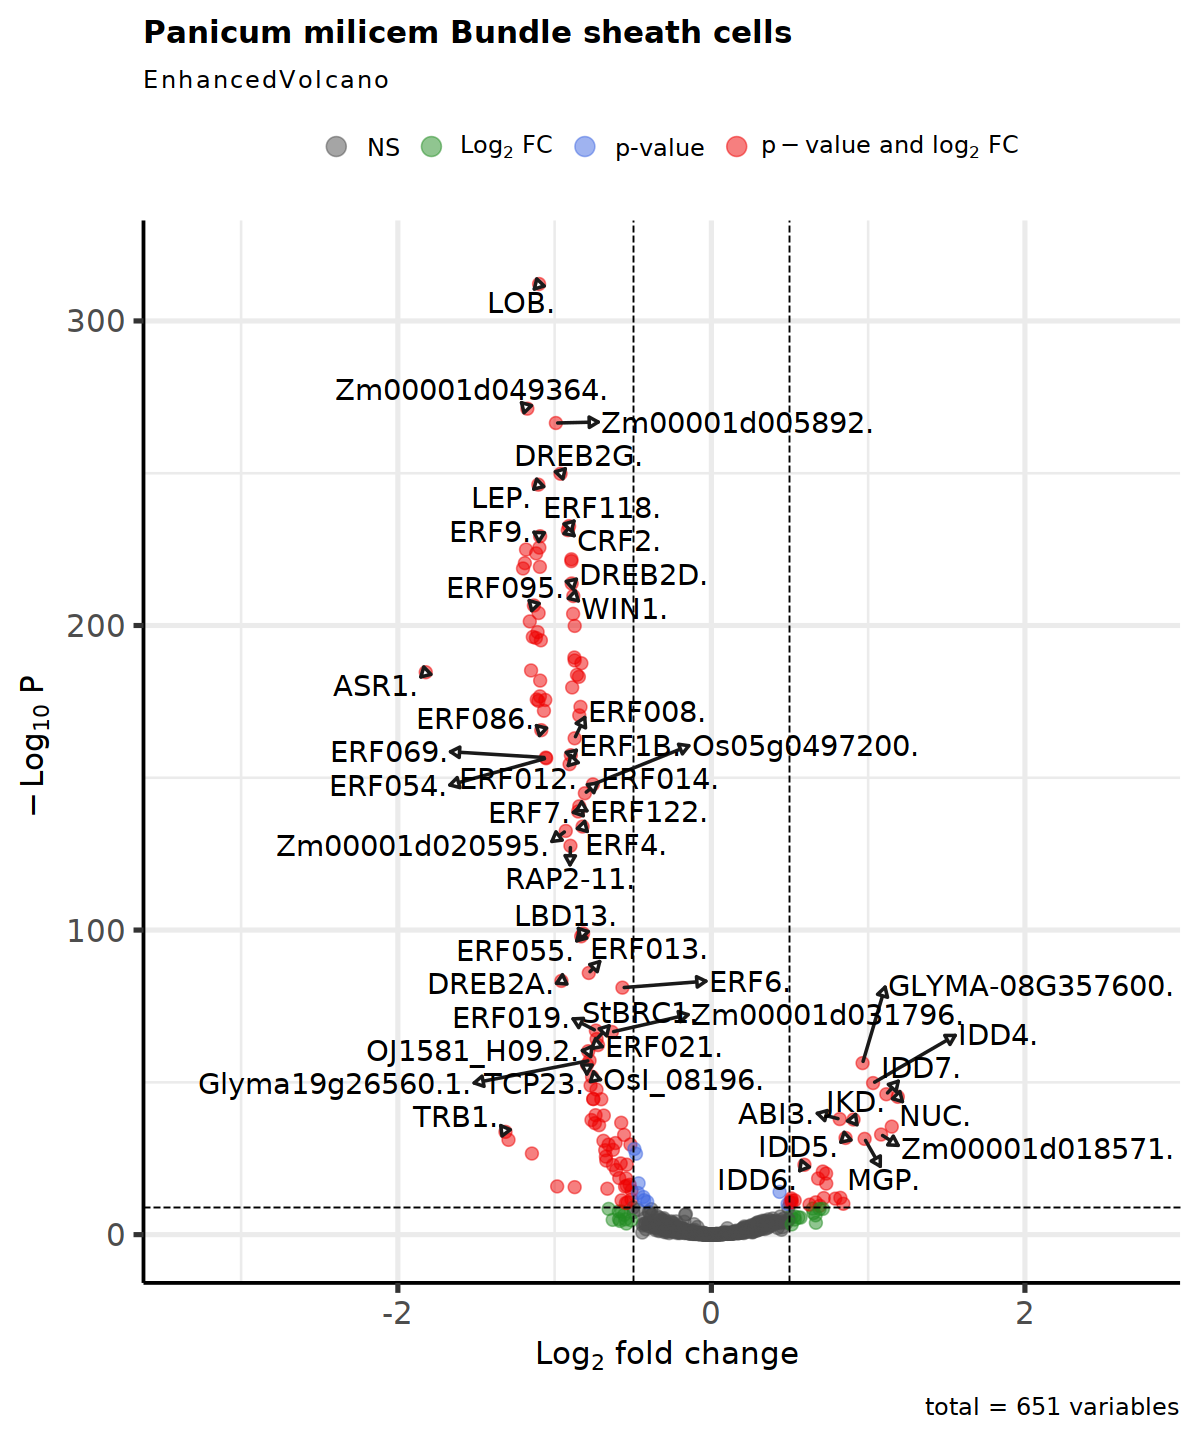

In [27]:
options(repr.plot.width=10, repr.plot.height=12)

EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'adjusted_pval',
    title = 'Panicum milicem Bundle sheath cells',
    pCutoff = 10e-10,
    FCcutoff = 0.5,
    pointSize = 3.0,
    labSize = 6.0,
    drawConnectors = TRUE,
    widthConnectors = 0.75)

# Mesophyll Try

In [15]:
    

mesophyll_control_acrs <- fimo_output %>% 
    dplyr::filter(ACR_number %in% mesophyll_control_ACRs_cell_type$ACR_number) %>% 
    group_by(motif_id, motif_alt_id, ACR_Class) %>% 
    summarise(control_counts = n()) %>% 
    mutate(control_class = "mesophyll") %>% 
    select(-ACR_Class) %>% 
    select(motif_id, control_class, control_counts)

`summarise()` has grouped output by 'motif_id', 'motif_alt_id'. You can
override using the `.groups` argument.
Adding missing grouping variables: `motif_alt_id`


In [16]:
cell_type_sepcific_acrs_contigency_meso <- left_join(cell_type_sepcific_acrs_contigency, number_cell_type_acrs, by = c("ACR_Class"))

In [17]:
cell_type_sepcific_acrs_contigency_w_log2_meso <- cell_type_sepcific_acrs_contigency_meso %>% 
    dplyr::mutate(fraction_cts_acrs_w_motif = counts/acr_per_ct) %>% 
    filter(!str_detect(ACR_Class, ",")) %>% 
    left_join(., mesophyll_control_acrs, by = c("motif_id","ACR_Class" = "control_class")) %>% 
    dplyr::filter(ACR_Class == "mesophyll") %>% 
    dplyr::mutate(fraction_control_w_motif = control_counts/acr_per_ct) %>% 
    rowwise() %>% 
    mutate(log2FoldChange = log2(fraction_cts_acrs_w_motif/fraction_control_w_motif),
            test_stat = chisq.test(c(counts, control_counts))$statistic,
            p_val = chisq.test(c(counts, control_counts))$p.value) %>% 
    ungroup() %>% 
    mutate(adjusted_pval = p.adjust(p_val, method="fdr")) %>% 
  group_by(motif_alt_id.x ) %>%
  mutate(row_num = case_when(n() > 1 ~ as.character(row_number()), TRUE ~ "")) %>%
  ungroup() %>%
  mutate(motif_alt_id = paste0(motif_alt_id.x ,".", row_num)) %>%
  select(-row_num)

    

In [18]:
calculate_chi_square_subset_meso <- cell_type_sepcific_acrs_contigency_w_log2_meso %>% 
    select(motif_alt_id, log2FoldChange, adjusted_pval)


calculate_chi_square_subset_meso.df <- as.data.frame(calculate_chi_square_subset_meso)
row.names(calculate_chi_square_subset_meso.df) <- calculate_chi_square_subset_meso.df$motif_alt_id
res_meso <- calculate_chi_square_subset_meso.df[,2:3]

In [19]:
res_meso

,log2FoldChange,adjusted_pval
,<dbl>,<dbl>
AGL3.,0.04654259,8.588638e-01
AG.,0.20759542,4.595577e-01
HAT5.,-0.05215128,8.218948e-01
Gam1.,-0.29168181,4.574974e-02
myb.Ph3.,0.14755719,6.495897e-01
squamosa.,-0.02748074,8.895787e-01
bZIP910.,0.63742992,9.794785e-03
bZIP911.,0.13271392,2.916704e-01
ATHB-5.,-0.13124453,5.739038e-01


In [20]:
arrange(calculate_chi_square_subset, by = adjusted_pval)

motif_alt_id,log2FoldChange,adjusted_pval
<chr>,<dbl>,<dbl>
LOB.,-1.0993141,7.401669e-313
Zm00001d049364.,-1.1741373,6.384700e-272
Zm00001d005892.,-0.9919220,3.268814e-267
DREB2G.,-0.9622993,1.484637e-250
LEP.,-1.1040393,5.790414e-247
ERF118.,-0.9077753,2.397462e-233
CRF2.,-0.9156743,4.824181e-232
ERF9.,-1.0924809,4.819405e-230
ERF115.,-1.0973533,2.709230e-226


In [21]:
calculate_chi_square_subset %>% 
    filter(str_detect(motif_alt_id, "DOF"))

motif_alt_id,log2FoldChange,adjusted_pval
<chr>,<dbl>,<dbl>
DOF2.5.,0.37514477,9.559995e-04
DOF1.8.,0.27905463,8.789938e-03
DOF2.4.,0.08817581,4.477563e-01
DOF5.6.,0.28667725,4.618731e-02
DOF5.7.,-0.07267750,4.859135e-01
DOF5.3.,0.14804794,8.732378e-02
DOF5.8.,-0.04418808,3.151860e-01
DOF4.5.,0.02160225,8.696931e-01
DOF3.2.,0.02904853,6.776440e-01


Warning message:
"ggrepel: 91 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


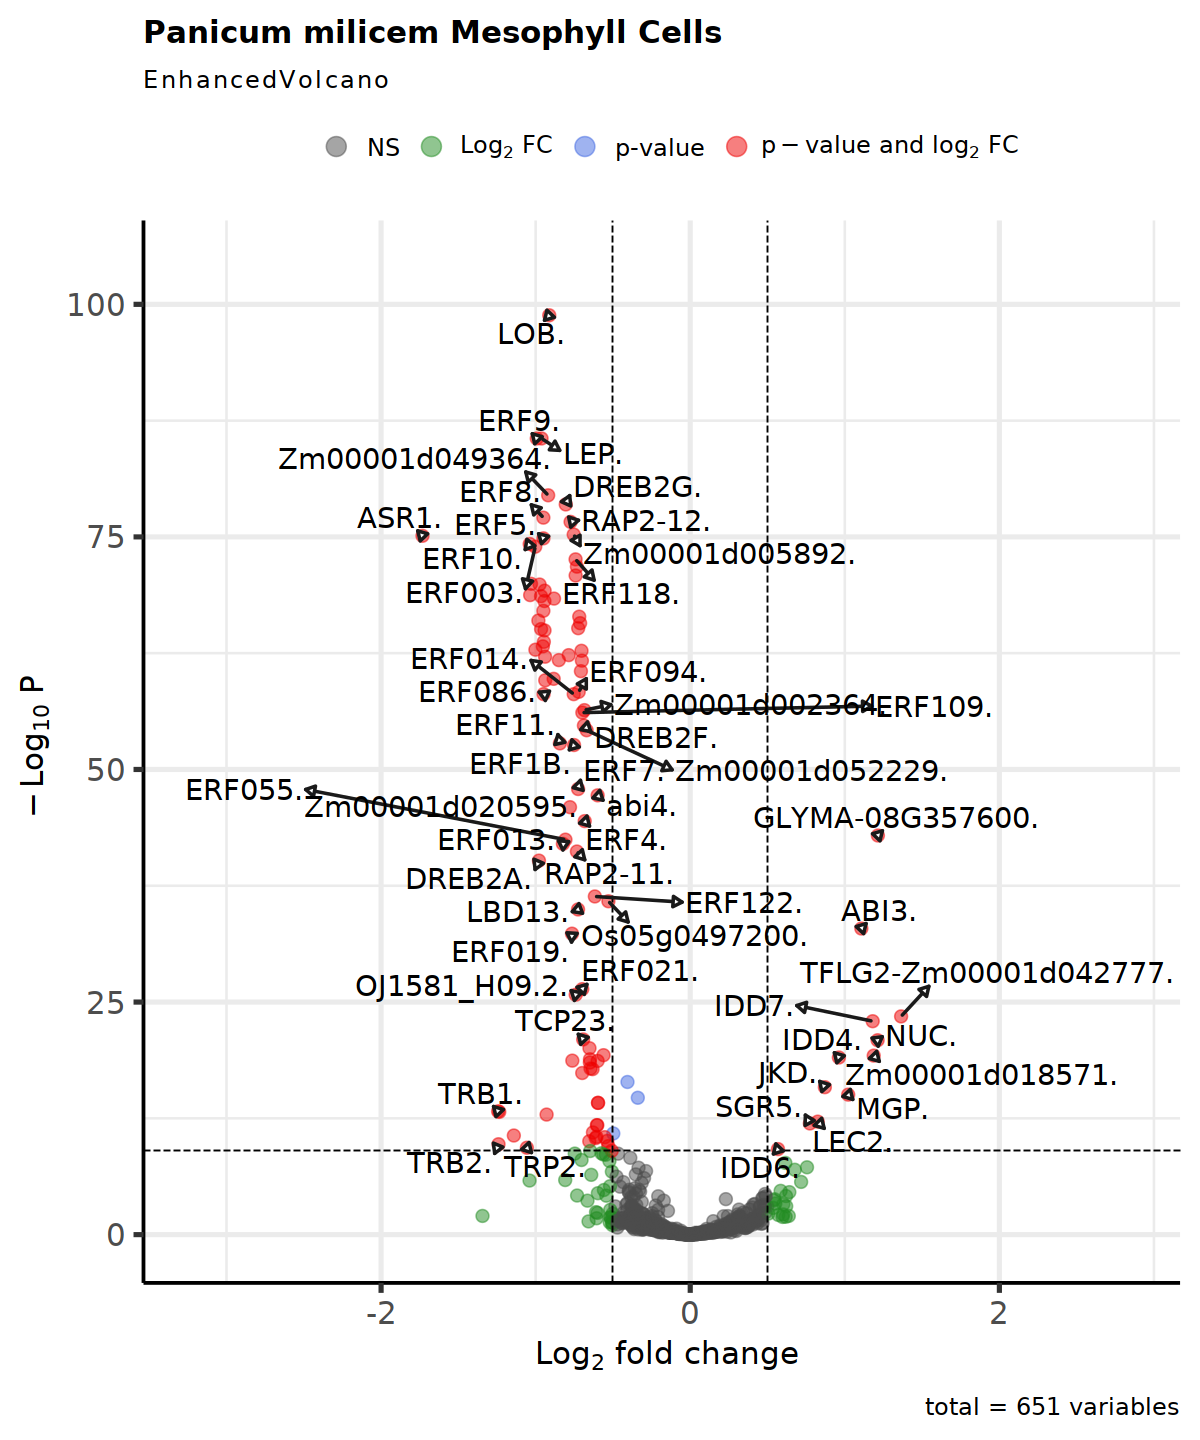

In [26]:
options(repr.plot.width=10, repr.plot.height=12)

EnhancedVolcano(res_meso,
    lab = rownames(res_meso),
    x = 'log2FoldChange',
    y = 'adjusted_pval',
    title = 'Panicum milicem Mesophyll Cells',
    pCutoff = 10e-10,
    FCcutoff = 0.5,
    pointSize = 3.0,
    labSize = 6.0,
    drawConnectors = TRUE,
    widthConnectors = 0.75)